# Chapter 2 Exercises

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm


np.random.seed(123)

## Exercise 1
***

*Using PyMC, change the parameters of the prior beta distribution in `our_first_model` to match those of the previous chapter. Compare the results to the previous chapter.*

Let first try with just four trials, and then with 150.

In [ ]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = pz.Bernoulli(p=theta_real).rvs(trials)

beta_params = [(1, 1), (20, 20), (1, 4)]
idatas0 = []
for alpha, beta in beta_params:
    with pm.Model() as model:
        θ = pm.Beta('θ', alpha=alpha, beta=beta)
        y = pm.Bernoulli('y', p=θ, observed=data)
        idata = pm.sample(random_seed=123)
        idatas0.append(idata)



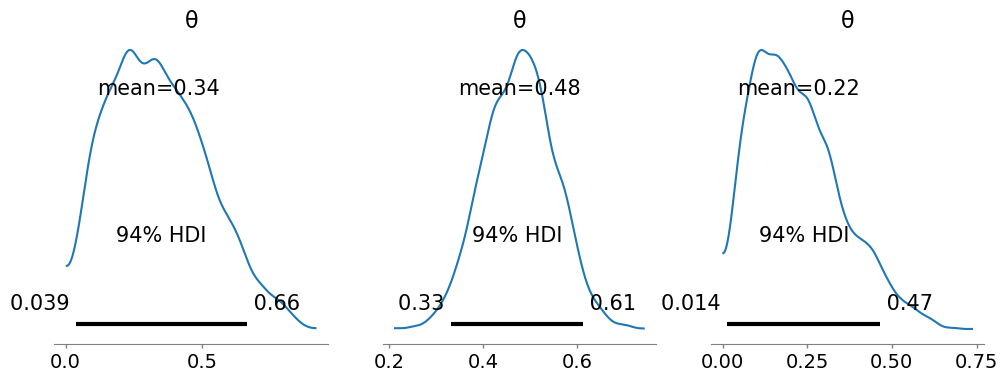

In [3]:
_, axes = plt.subplots(1,3, figsize=(12, 4))
for idata, ax in zip(idatas0, axes):
    az.plot_posterior(idata, ax=ax);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

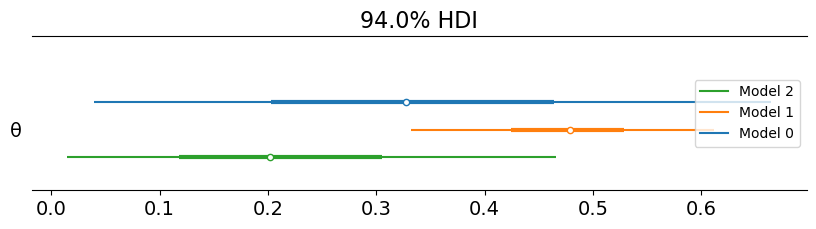

In [4]:
az.plot_forest(idatas0, combined=True, figsize=(10, 2))

In [5]:
trials = 150
theta_real = 0.35  # unknown value in a real experiment
data = pz.Bernoulli(p=theta_real).rvs(trials)

beta_params = [(1, 1), (20, 20), (1, 4)]
idatas1 = []
for alpha, beta in beta_params:
    with pm.Model() as model:
        θ = pm.Beta('θ', alpha=alpha, beta=beta)
        y = pm.Bernoulli('y', p=θ, observed=data)
        idata = pm.sample(random_seed=123)
        idatas1.append(idata)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


To see the results we can use different alternatives. Let's try with `plot_posterior`

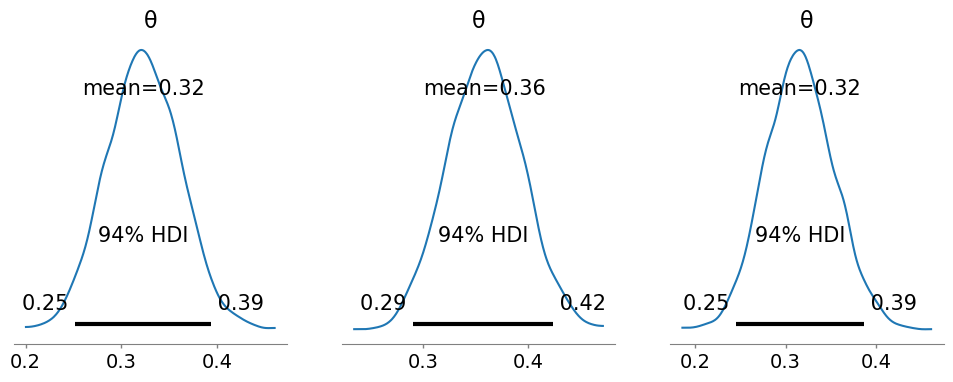

In [6]:
_, axes = plt.subplots(1,3, figsize=(12, 4))
for idata, ax in zip(idatas1, axes):
    az.plot_posterior(idata, ax=ax);

When comparing posteriors of different models `plot_forest` can be a good choice

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

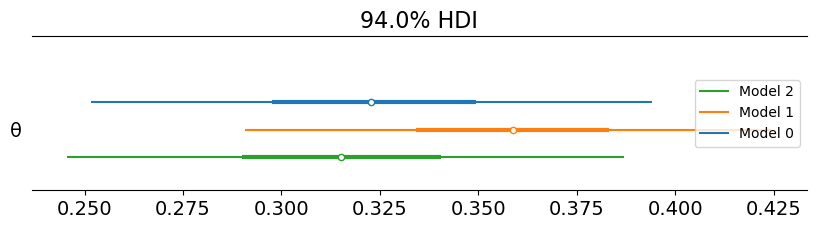

In [7]:
az.plot_forest(idatas1, combined=True, figsize=(10, 2))

## Exercise 2
***

Compare the model `our_first_model` with prior $\theta \sim \text{Beta}(1, 1)$ with a model with prior $\theta \sim \mathcal(U)(0, 1)$. Are the posteriors similar or different? Is the sampling slower, faster, or the same?*

### Replace the beta distribution with a uniform one in the interval [0,1]

In [8]:
with pm.Model() as our_first_model:
    θ = pm.Uniform('θ', lower=0, upper=1)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata_uniform_1_1 = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


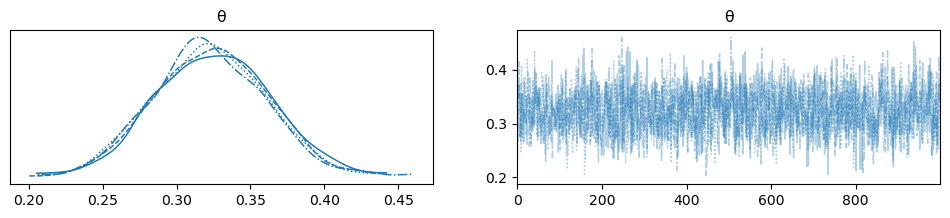

In [9]:
az.plot_trace(idata_uniform_1_1);

In [10]:
beta_1_1 = az.summary(idatas1[0], kind="stats")
uniform_1_1 = az.summary(idata_uniform_1_1, kind="stats")
pd.concat([beta_1_1, uniform_1_1])

,mean,sd,hdi_3%,hdi_97%
θ,0.323,0.038,0.252,0.394
θ,0.323,0.038,0.252,0.394


### Discussion
Both priors produce identical results. This is to be expected as a $Beta(1,1)$ prior is exactly the same as a $Uniform(0,1)$ prior. I encourage you to prove it to yourself by plotting both. Furthermore, the models sampling times are identical as well.

*What about using a Uniform over a different interval such as [-1, 2]? Does the model run? What errors do you get?*

In [11]:
with pm.Model() as our_first_model:
    θ = pm.Uniform('θ', lower=-1, upper=2)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata_uniform_minus_1_2 = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [12]:
our_first_model.debug()

point={'θ_interval__': array(0.)}

No problems found


In [13]:
beta_1_1 = az.summary(idatas1[0], kind="stats")
uniform_minus_1_2 = az.summary(idata_uniform_minus_1_2, kind="stats")
pd.concat([beta_1_1, uniform_minus_1_2])

,mean,sd,hdi_3%,hdi_97%
θ,0.323,0.038,0.252,0.394
θ,0.323,0.038,0.253,0.395


Even when the model is misspecified PyMC manages to compute the correct result. This will not always be the case. For some models it could give a `SamplingError`, the reason is that PyMC needs to start from a valid point (details are discussed in Chapter 10). For this model, a valid point is a value of $\theta$ between 0 and 1. In this example even when the prior `pm.Uniform('θ', lower=-1, upper=2)` is outside that range PyMC manages to get a valid point from it. We can ask PyMC if everything is right with.

In [14]:
our_first_model.debug()

point={'θ_interval__': array(0.)}

No problems found


And it tell us that it was not able to find problems. For other priors we may be not that lucky. Let's define a model with a different prior and then ask PyMC if the model is ok.

In [15]:
with pm.Model() as a_model:
    θ = pm.Uniform('θ', lower=-2, upper=1)
    y = pm.Bernoulli('y', p=θ, observed=data)
    
a_model.debug()

point={'θ_interval__': array(0.)}

The variable y has the following parameters:
0: Add [id A] <Scalar(float64, shape=())> 'θ'
 ├─ Sigmoid [id B] <Scalar(float64, shape=())>
 │  └─ θ_interval__ [id C] <Scalar(float64, shape=())>
 └─ Mul [id D] <Scalar(float64, shape=())>
    ├─ -2.0 [id E] <Scalar(float64, shape=())>
    └─ Sub [id F] <Scalar(float64, shape=())>
       ├─ 1.0 [id G] <Scalar(float64, shape=())>
       └─ Sigmoid [id B] <Scalar(float64, shape=())>
          └─ ···
The parameters evaluate to:
0: -0.5
This does not respect one of the following constraints: 0 <= p <= 1

You can set `verbose=True` for more details


Here we can see that `a_model.debug()` is telling that PyMC is trying to sample from $\theta=-0.5$, which is not a valid value for the p parameter from the Bernoulli distribution. 

If we try to sample from this model we will get an error.

In [16]:
with  a_model:
    idata_uniform_minus_1_2 = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'θ_interval__': array(-0.62652526)}

Logp initial evaluation results:
{'θ': -1.48, 'y': -inf}
You can call `model.debug()` for more details.

## Exercise 3
***

*PyMC has a function pm.model_to_graphviz that can be used to visualize the model. Use it to visualize the model our_first_model. Compare the result with the Kruschke diagram. Use pm.model_to_graphviz to visualize model comparing_groups.*

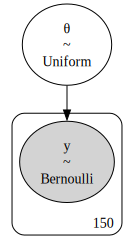

In [17]:
pm.model_to_graphviz(our_first_model)

In recent versions of PyMC we also have this functionality as a method of the model.

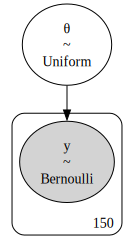

In [18]:
our_first_model.to_graphviz()

## Exercise 4
***

*Read about the [coal mining disaster model](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#case-study-2-coal-mining-disasters) that is part of the PyMC documentation. Try to implement and run this model by yourself.*

## Exercise 5
***

*Modify `model_g`: change the prior for the mean to a Gaussian distribution centered at the empirical mean, and play with a couple of reasonable values for the standard deviation of this prior. How robust/sensitive are the inferences to these changes? What do you think of using a Gaussian, which is an unbounded distribution (goes from $-\infty$ to $+\infty$), to model bounded data such as this? Remember that we said it is not possible to get values below 0 or above 100.*

First let's load the data and calculate the mean and standard deviation

In [19]:
data = np.loadtxt('../code/data/chemical_shifts.csv')

In [20]:
empirical_mean = np.mean(data)
empirical_std = np.std(data)
empirical_mean, empirical_std

(53.49645833333333, 3.4200063898474258)

Next, let's create a model with a prior parametrized by $\mu \text{~} N(53, \sigma)$. Since we want to test the effect of various $\sigma$ values, we'll assume that values of [1.5, 3.0, 5.0] are reasonable priors parameters. We'll also add one unreasonable $\sigma$ of 1000 for comparison.

In [21]:
idatas_g = []
sd_priors = [1.5, 3, 5, 1000]

for sd_prior in sd_priors:
    with pm.Model() as model_g:
        # Modified prior to Gaussian
        μ = pm.Normal(f'μ_prior_{sd_prior}', mu=empirical_mean, sigma=sd_prior)
        σ = pm.HalfNormal('σ', sigma=5)
        y = pm.Normal('y', mu=μ, sigma=σ, observed=data)
        idata = pm.sample()
        idatas_g.append(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_prior_1.5, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_prior_3, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_prior_5, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_prior_1000, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [22]:
summaries = [az.summary(idata, kind="stats") for idata in idatas_g]
pd.concat(summaries).T

,μ_prior_1.5,σ,μ_prior_3,σ,μ_prior_5,σ,μ_prior_1000,σ
mean,53.501,3.522,53.486,3.540,53.507,3.529,53.509,3.529
sd,0.489,0.376,0.498,0.371,0.513,0.371,0.495,0.368
hdi_3%,52.645,2.891,52.517,2.895,52.571,2.849,52.560,2.819
hdi_97%,54.466,4.264,54.406,4.250,54.502,4.210,54.417,4.178


Looking at the summaries, the combination of the model and inference technique seems quite robust to the changes. Even with a prior that is 300x larger than the empirical prior, the posterior values converge to approximately the same result. Computationally there seems to be very little difference.

Logically, however, there could be some questions about the choice of an unbounded prior. Since it is not possible to get values below 0 or above 100, it doesn't make practical sense to have a prior that exists for those values.

## Exercise 6
***

*Using the data from the chemical_shifts.csv file, compute the empirical mean and the standard deviation with and without outliers. Compare those results to the Bayesian estimation using the Gaussian and Student’s t-distribution. What do you observe?*

Let's first compute the mean and standard deviation without removing any data:

In [23]:
data = np.loadtxt('../code/data/chemical_shifts.csv')
empirical_mean, empirical_std = np.mean(data), np.std(data)
empirical_mean, empirical_std

(53.49645833333333, 3.4200063898474258)

Then let's let's identify outliers by using the _2x standard deviation_ methodology:

In [24]:
outlier_mask = ~(np.abs(data-empirical_mean) < empirical_std*2)
data[outlier_mask]

array([63.43, 68.58])

Removing those two values, let's recompute the mean and standard deviation:

In [25]:
empirical_mean_no_outliers = np.mean(data[~outlier_mask])
empirical_std_no_outliers = np.std(data[~outlier_mask])

empirical_mean_no_outliers, empirical_std_no_outliers

(52.95260869565218, 2.1950303897892387)

Notice that the mean has dropped from 53.49 to 52.95, and the standard deviation has dropped from 3.42 to 2.19. Logically this makes sense as the data is "less spread out" when we don't include  outliers. We can see that the estimates we got by dropping the outliers are closer to the ones using the Student's t-distribution (53.02, 2.21) and the estimates without dropping data are closer to those obtained with the Gaussian model (53.50, 3.52).

## Exercise 7
***

*Repeat the previous exercise by adding more outliers to chemical_shifts.csv, and compute new posteriors for model_g and model_t using this new data. What do you observe?*

In [26]:
# Create an array with the outliers repeated 4 times
additional_outliers = np.repeat(data[outlier_mask], 4)

# Concatenate the original data array and the additional outliers
data_more_outliers = np.concatenate([data, additional_outliers])
data_more_outliers

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16, 63.43, 63.43, 63.43, 63.43, 68.58, 68.58,
       68.58, 68.58])

In [27]:
empirical_mean_more_outliers = np.mean(data_more_outliers)
empirical_std_more_outliers = np.std(data_more_outliers)

empirical_mean_more_outliers, empirical_std_more_outliers

(55.28339285714286, 5.489222647537144)

The mean and standard deviation both go up in this case. This intuitively makes sense because the distribution needs to "stretch" to include these additional data points that are farther away from the mean.

In [28]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data_more_outliers)
    idata_g = pm.sample(random_seed=4591)

with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', nu=ν, mu=μ, sigma=σ, observed=data_more_outliers)
    idata_t = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [29]:
az.summary(idata_g, kind="stats")

,mean,sd,hdi_3%,hdi_97%
μ,55.295,0.727,53.961,56.662
σ,5.593,0.544,4.627,6.651


In [30]:
az.summary(idata_t, kind="stats")

,mean,sd,hdi_3%,hdi_97%
μ,53.380,0.587,52.389,54.530
σ,2.752,0.780,1.496,4.312
ν,2.784,6.337,0.798,4.444


Again we can see that the estimates with model_t are closer to those of the data without outliers and the estimated for model_g are closer to the empirical values with outliers

## Exercise 8
***

*Explore the InferenceData object idata_cg.*

Let's first load the data and recreate the idata_cg object

In [31]:
tips = pd.read_csv('../code/data/tips.csv')
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [32]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample(random_seed=4591)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg, random_seed=4591))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


### *How many groups does it contain?*

In [33]:
idata_cg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

It has four groups

### *Inspect the posterior distribution of the parameter $\mu$ for a specific day using the sel method.*

In [34]:
μ_friday = idata_cg.posterior["μ"].sel(days="Fri")
μ_friday

<xarray.DataArray 'μ' (chain: 4, draw: 1000)>
array([[2.69558343, 2.51267291, 2.73090966, ..., 2.93931696, 3.12108709,
        3.05620101],
       [2.80562663, 2.57380463, 2.7478089 , ..., 2.28789735, 2.78000907,
        2.0969152 ],
       [2.58408016, 2.74994768, 2.696745  , ..., 3.1301347 , 2.22148579,
        2.43648245],
       [2.90730223, 2.88724236, 2.92773375, ..., 2.52747385, 2.63502192,
        2.73838129]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    days     <U4 'Fri'

In [35]:
μ_friday.mean()

<xarray.DataArray 'μ' ()>
array(2.75898353)
Coordinates:
    days     <U4 'Fri'

### *Compute the distributions of mean differences between Thursday and Sunday.*

What are the coordinates and dimensions of the resulting DataArray?

In [36]:
idata_cg.posterior["μ"].sel(days="Thur") - idata_cg.posterior["μ"].sel(days="Sun")

<xarray.DataArray 'μ' (chain: 4, draw: 1000)>
array([[-0.36099177, -0.42817472, -0.48024207, ..., -0.57833749,
        -0.52982564, -0.44411045],
       [-0.29848832, -0.87876167, -0.42309797, ..., -0.63599383,
        -0.37926279, -0.18285751],
       [-0.27185075, -0.56314496, -0.31814309, ..., -0.39973599,
        -0.41793068, -0.18353456],
       [-0.62637595, -0.67158215, -0.25265306, ..., -0.24890702,
        -0.42064777, -0.52351591]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

## Exercise 9
***

*Compute the probability of superiority directly from the posterior (without computing Cohen's d first). You can use the `pm.sample_posterior_predictive()` function to take a sample from each group. Is it really different from the calculation assuming normality? Can you explain the result?*


### Step 2: Get posterior predictive values per group
In our case, let's see if Sunday is superior to Thursday in regards to tips. 

In our code, recall that:
* We have 244 items
* We encoded the string labels of days into "codes" or integers
* Sunday was encoded as 3, Thursday was encoded as 0

In [37]:
# Get our model's predictions for possible tips on Thursday and Sunday
posterior_predictive_thursday =  idata_cg.posterior_predictive["y"].sel(days_flat="Thur").stack(samples=("chain", "draw", "days_flat"))
posterior_predictive_sunday = idata_cg.posterior_predictive["y"].sel(days_flat="Sun").stack(samples=("chain", "draw", "days_flat"))

Just to get a sense of the distributions, let's plot them:

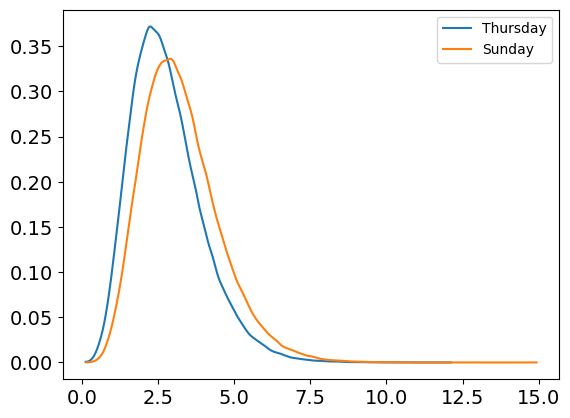

In [38]:
az.plot_kde(posterior_predictive_thursday.values, label="Thursday");
az.plot_kde(posterior_predictive_sunday.values, plot_kwargs={"color":"C1"}, label="Sunday");

In [39]:
thursday_tip_draws = np.random.choice(posterior_predictive_thursday, replace=True, size=1000)
sunday_tip_draws = np.random.choice(posterior_predictive_sunday, replace=True, size=1000)

(thursday_tip_draws > sunday_tip_draws).mean()

0.37

We obtained a very similar result to the calculation we obtained in Figure 2.21. This means that, given a tip on Thursday, there is only a 4 in 10 chance that it will be higher than a tip on Sunday. In other words, you should sign up for Sunday shifts if you're looking to make extra money! I encourage you to try using different days to compare other groups.